## Plotting WPC Probabilistic Precipitation Guidance for Days 1-3

**Grib files found here: https://ftp.wpc.ncep.noaa.gov/pqpf/conus/**

**I typicaly use the cfgrib engine in xarray for reading grib/grib2 files as it does a nicer job of formatting and makes 
extracting metadata like times and dates easier. Cfgrib however, has difficulty differentiating some grib files that contain different level 
types (hybrid and isobaric) for the same variable, or variables that share the same coordinate (as is the case here). Sometimes you can 
get around this by filtering certain keys, but the variables names in these grib files are so similar, I cant find a way to filter it - so I'll use the 
PyNIO engine within xarray instead. More info on the cfgrib issue here: https://github.com/ecmwf/cfgrib#filter-heterogeneous-grib-files**

In [1]:
import xarray as xr
import Nio
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.shapereader as shprdr
import matplotlib.pyplot as plt
import matplotlib.colors as col

First, here is an example of what cfgrib does when you try to open this file with xarray and the cfgrib engine. The cfgrib library will need to be installed if it's not already.

In [2]:
test = xr.open_dataset("/data/pqpf_p06i_conus_latest_f042.grb", engine="cfgrib")
test

<xarray.Dataset>
Dimensions:     (y: 1597, x: 2145)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    tp          (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          5
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-10-18T00:43 GRIB to CDM+CF via cfgrib-0.9.1...

This will only give the first variable in the file ('tp') and then completely ignore the others because they have the same 
name and share a similar coordinate (which doesnt even show up in this case, but it would be the probability values).

Now we'll open the grib file using xarray and the PyNIO engine. 
The PyNIO library will need to be installed if it's not already.

In [3]:
probqpf = xr.open_dataset("/data/pqpf_p06i_conus_latest_f042.grb", engine="pynio")
probqpf

<xarray.Dataset>
Dimensions:                (APCP_probability0: 11, ygrid_0: 1597, xgrid_0: 2145)
Coordinates:
    gridlat_0              (ygrid_0, xgrid_0) float32 ...
    gridlon_0              (ygrid_0, xgrid_0) float32 ...
  * APCP_probability0      (APCP_probability0) float32 0.254 2.54 ... 76.2 101.6
Dimensions without coordinates: ygrid_0, xgrid_0
Data variables:
    APCP_P9_L1_GLC0_acc6h  (APCP_probability0, ygrid_0, xgrid_0) float32 ...
    gridrot_0              (ygrid_0, xgrid_0) float32 ...

Taking a look at this file, the precipitation probability variable **APCP_P9_L1_GLC0_acc6h** has 1 coordinate and 2 dimensions 
attached to it: **APCP_probability0, ygrid_0, xgrid_0**.

We can also view the 11 probability values contained in the **APCP_probability0** array attached to **APCP_P9_L1_GLC0_acc6h**. 
Note these values are in mm, so in inches: **0.01", 0.1", 0.25", 0.5", 0.75", 1", 1.5", 2", 2.5", 3", 4"**.

In [4]:
probqpf.coords['APCP_probability0'] # Use '.coords' to access the coordinate arrays of the file

<xarray.DataArray 'APCP_probability0' (APCP_probability0: 11)>
array([  0.254,   2.54 ,   6.35 ,  12.7  ,  19.05 ,  25.4  ,  38.1  ,  50.8  ,
        63.5  ,  76.2  , 101.6  ], dtype=float32)
Coordinates:
  * APCP_probability0  (APCP_probability0) float32 0.254 2.54 ... 76.2 101.6
Attributes:
    long_name:  Total precipitation probability limits
    units:      kg m-2

You can access each probability value, by using the index of that value in the **APCP_probability0** array. 
Here is an example showing a quick plot of the 6-hr probability of ≤ 0.1" of precipitation, which would be the 1st index from that array. Remember the order of coords and dimensions in the precipitation probability variable we are plotting is **APCP_probability0, ygrid_0, xgrid_0**, so we use **probqpf['APCP_P9_L1_GLC0_acc6h'][1]**, where the '[1]' can be replaced with any index number from the **APCP_probability0** array.

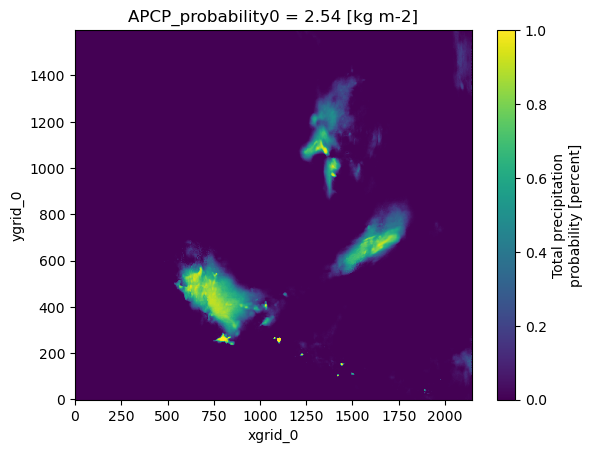

In [5]:
probqpf['APCP_P9_L1_GLC0_acc6h'][1].plot()

#### Plotting the data

In [6]:
# Create the CRS for the plotted map
map_crs = ccrs.AlbersEqualArea(central_longitude=-79.0, 
                               central_latitude=35.5, 
                               standard_parallels=(34.33,36.16)
                              )

# Create the CRS for lat/lon points (lat/lon is always PLateCarree)
latlon_crs = ccrs.PlateCarree()

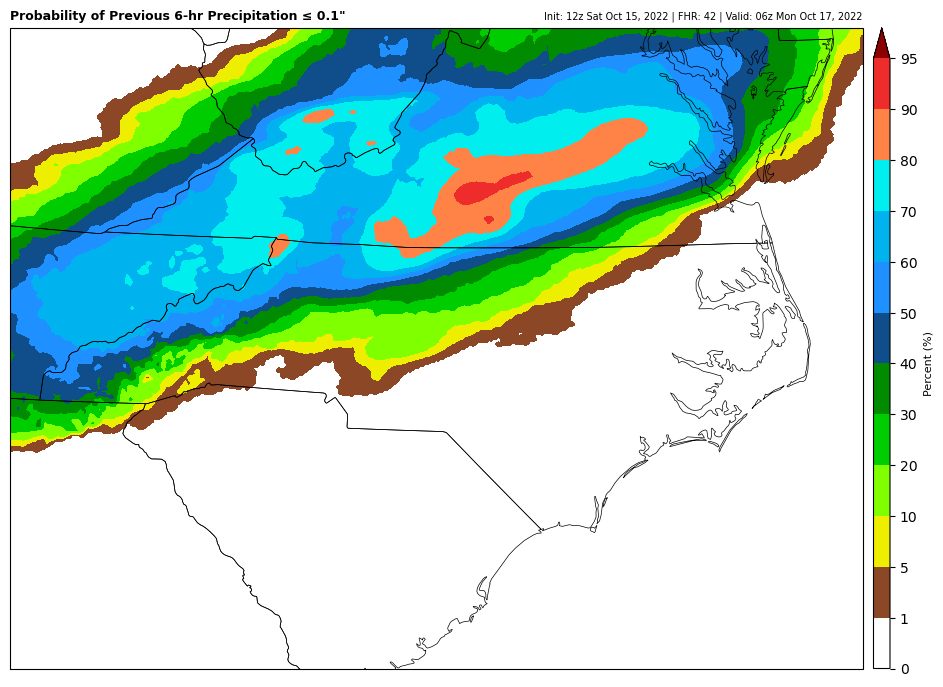

In [7]:
# Create a map showing WPC Probabilistic Precipitation Guidance.
# ---------------------------------------------------------------

fig = plt.figure(1, figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=map_crs) # Set our map to be drawn with the 'map_crs' CRS we defined earlier

# Set the lat/lon extent to be plotted
ax.set_extent([-84.5,-75,32.5,38.5])

# Set the background color to white
ax.set_facecolor("white")

# Read in custom shapefiles
STATE = cfeat.ShapelyFeature(shprdr.Reader('/data/ne_10m_admin_1_states_provinces.shp').geometries(), latlon_crs)

# Plot the states and counties
ax.add_feature(STATE, facecolor='whitesmoke', zorder=1)
ax.add_feature(STATE, facecolor='none', edgecolor='black', linewidth=0.5, zorder=3)

#Grab and parse times for our title
init_time = probqpf['APCP_P9_L1_GLC0_acc6h'].attrs['initial_time'] # Grab the initial time of the model run.
fhr = int(probqpf['APCP_P9_L1_GLC0_acc6h'].attrs['forecast_time']) # Grab the forecast hour.
init_time = dt.datetime.strptime(init_time, '%m/%d/%Y (%H:%M)') # Parse the 'init_time' string into a datetime object.
valid_time = init_time + dt.timedelta(hours = fhr) # Get the datetime object for the 'valid_time' using the fhr time delta.
init_time = init_time.strftime('%Hz %a %b %d, %Y') # Format 'init_time' into the format we want to use for plotting.
valid_time = valid_time.strftime('%Hz %a %b %d, %Y') # Format 'valid_time' into the format we want to use for plotting.
prcp_prob_val = probqpf.coords['APCP_probability0'][1] # Manually get the precip prob value we are plotting
prcp_prob_val = round(prcp_prob_val.values.item() / 25.4, 2) # Convert to inches and round to 2 decimals

# Plot the title, its location and font size
title_left = 'Probability of Previous 6-hr Precipitation ≤ ' + str(prcp_prob_val) + '"'
title_right = 'Init: ' + init_time + ' | FHR: ' + str(fhr) + ' | ' + 'Valid: ' + valid_time
plt.title(title_left, fontsize=9, fontweight='bold', loc='left')
plt.title(title_right, fontsize=7, loc='right')

# Create a list of contour levels
clevs = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

# Create the custom color map of hex values
cmap = col.ListedColormap(['#ffffff', '#8b4726', '#eeee00', '#7fff00', '#00cd00', '#008b00',
                           '#104e8b', '#1e90ff', '#00b2ee', '#00eeee', '#ff8247', '#ee2c2c',
                           '#8b0000'
                           ]) # WPC Prob QPF Color Map

# Generates the colormap index based on discrete intervals
norm = col.BoundaryNorm(clevs, ncolors=cmap.N, extend='max')

# Plot the accumulated precipitation as a contour fill
s = ax.contourf(probqpf["gridlon_0"], probqpf["gridlat_0"], probqpf['APCP_P9_L1_GLC0_acc6h'][1] * 100, 
                transform=latlon_crs, 
                norm=norm, 
                cmap=cmap, 
                levels=clevs, 
                zorder=2, 
                extend='max')

# Make new axis for the color bar and plot it on the right
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.015,ax.get_position().height])
cb = plt.colorbar(s, cax=cax, ticks=clevs)

cb.set_label("Percent (%)", size=8) # Color bar label

# Save the image
plt.savefig("/data/WPC_06hr_Prob_" + str(prcp_prob_val) + "QPE.png", dpi=100, bbox_inches='tight', facecolor='white')